### Imports

In [1]:
import scipy.io.wavfile as wav
import scipy.signal as signal
from matplotlib import pyplot as plt
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn.functional as F
import gc

### Generate Images

In [2]:
path = "genres_original"
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
train_save_path = "train_genres_images"
test_save_path = "test_genres_images"
num_divisions = 5
max_per_genre = 350
clip_length = 0
train_per_test = 10

if (False):
    for genre in genres:
        files = [f for f in os.listdir(path + "/" + genre) if os.path.isfile(os.path.join(path + "/" + genre, f))]
        print("Generating " + genre)
        os.makedirs(os.path.dirname(train_save_path + "/" + genre + "/"), exist_ok=True) # make path if doesn't exist
        os.makedirs(os.path.dirname(test_save_path + "/" + genre + "/"), exist_ok=True) # make path if doesn't exist
        
        n=0
        for file in files:
            if(n>=max_per_genre):
                break
                
            if(file == "jazz.00054.wav"):
                continue
            else:
                sample_rate, samples = wav.read(path + "/" + genre + "/" + file) # extract audio)
                    
            # convert to mono
            if len(samples.shape) > 1:
                # Do a mean of all channels and keep it in one channel
                samples = np.mean(samples, axis=1)
    
            # pad so divisible by num_divisions
            samples = np.append(samples, np.zeros(num_divisions - (len(samples) % num_divisions)))
    
            # perform STFT on 6sec samples
            clip_samples = np.split(samples, num_divisions, axis=0)
            clip_length = len(clip_samples[0])
            start = clip_length // 2
            end = start + clip_length
            
            while (end < len(samples)):
                clip_samples.append(samples[start: end])
                start = end
                end = end + clip_length
    
            i=0
            for sample in clip_samples:
                SFT = signal.ShortTimeFFT.from_window(win_param='tukey', 
                                                      fs=sample_rate, 
                                                      nperseg=sample_rate//20,      #make 20Hz minimum sampled frequency
                                                      noverlap=(sample_rate//20)//2,  #50% overlap
                                                      fft_mode='onesided', 
                                                      scale_to='magnitude', 
                                                      phase_shift=None,
                                                      symmetric_win=True)
                Zxx = SFT.stft(sample)
                t = SFT.t(len(sample))
                f = SFT.f
                
                if(n%train_per_test == 0):
                    np.save(test_save_path + "/" + genre + "/" + genre + "_" + str((n*len(clip_samples))+i) + "_Z.npy", Zxx)
                    np.save(test_save_path + "/" + genre + "/" + genre + "_" + str((n*len(clip_samples))+i) + "_T.npy", t)
                    np.save(test_save_path + "/" + genre + "/" + genre + "_" + str((n*len(clip_samples))+i) + "_F.npy", f)
                else:
                    np.save(train_save_path + "/" + genre + "/" + genre + "_" + str((n*len(clip_samples))+i) + "_Z.npy", Zxx)
                    np.save(train_save_path + "/" + genre + "/" + genre + "_" + str((n*len(clip_samples))+i) + "_T.npy", t)
                    np.save(train_save_path + "/" + genre + "/" + genre + "_" + str((n*len(clip_samples))+i) + "_F.npy", f)
                    
                i+=1
            n+=1
    
    

### Run CNN

In [3]:
# Define the device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
#device = 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Custom Dataset class
class NumpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.Zsamples = []
        self.Tsamples = []
        self.Fsamples = []
        
        # Load file paths and labels
        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    if file_name.endswith("Z.npy"):
                        file_path = os.path.join(class_path, file_name)
                        self.Zsamples.append((file_path, label))
                    elif file_name.endswith("T.npy"):
                        file_path = os.path.join(class_path, file_name)
                        self.Tsamples.append((file_path, label))
                    elif file_name.endswith("F.npy"):
                        file_path = os.path.join(class_path, file_name)
                        self.Fsamples.append((file_path, label))
    
    def __len__(self):
        return len(self.Zsamples)
    
    def __getitem__(self, idx):
        file_path, label = self.Zsamples[idx]
        data = np.load(file_path)  # Load numpy array
        real = np.real(data)
        imag = np.imag(data)
        mag = np.abs(data)
        angle = np.angle(data)
        real = np.expand_dims(real, axis=0)
        imag = np.expand_dims(imag, axis=0)
        mag = np.expand_dims(mag, axis=0)
        angle = np.expand_dims(angle, axis=0)
        data = np.concatenate((real, imag, mag, angle), axis=0)
        data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor
        
        if self.transform:
            data = self.transform(data)
        
        return data, label

    def spectrograms(self, idx):
        Zfile_path, label = self.Zsamples[idx]
        Tfile_path, label = self.Tsamples[idx]
        Ffile_path, label = self.Fsamples[idx]
        Zdata = np.load(Zfile_path)  # Load numpy array
        Tdata = np.load(Tfile_path)  # Load numpy array
        Fdata = np.load(Ffile_path)  # Load numpy array
        print(Zdata.shape)
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(5, 1, figsize=(10, 16))
        
        # First subplot
        c1 = axes[0].pcolormesh(Tdata, Fdata, np.log(np.abs(Zdata)), cmap='gnuplot')
        fig.colorbar(c1, ax=axes[0])
        axes[0].set_title("Spectrogram Magnitude")
        
        # Second subplot
        c2 = axes[1].pcolormesh(Tdata, Fdata, np.angle(Zdata), cmap='gnuplot')
        fig.colorbar(c2, ax=axes[1])
        axes[1].set_title("Spectrogram Angle")      

        # Third subplot
        c3 = axes[2].pcolormesh(Tdata, Fdata, np.log(np.square(np.real(Zdata))), cmap='gnuplot')
        fig.colorbar(c3, ax=axes[2])
        axes[2].set_title("Spectrogram Real")  

        # Fourth subplot
        c4 = axes[3].pcolormesh(Tdata, Fdata, np.log(np.square(np.imag(Zdata))), cmap='gnuplot')
        fig.colorbar(c4, ax=axes[3])
        axes[3].set_title("Spectrogram Imag")  

        # Fifth subplot
        c5 = axes[4].pcolormesh(Tdata, Fdata, np.log(np.square(np.imag(Zdata)) + np.square(np.real(Zdata))), cmap='gnuplot')
        fig.colorbar(c4, ax=axes[4])
        axes[4].set_title("Spectrogram Imag + Real") 

In [5]:
# Define the transformations
# - ToTensor: Converts the image to a PyTorch tensor
# - Normalize: Normalizes using mean and std of the ImageNet dataset
transform = transforms.Compose([
    transforms.CenterCrop((544, 240)),
    transforms.Normalize((0,), (0.5,))
])

In [6]:
train_root_dir = "train_genres_images/"
test_root_dir = "test_genres_images/"

train_dataset = NumpyDataset(root_dir=train_root_dir, transform=transform)
test_dataset = NumpyDataset(root_dir=test_root_dir, transform=transform)

print(len(train_dataset))
print(len(test_dataset))

24120
2691


In [7]:
train_dataset[0][0].shape

torch.Size([4, 544, 240])

(552, 242)


C:\Users\Joshu\AppData\Local\Temp\ipykernel_16316\3763727857.py:74: RuntimeWarning: divide by zero encountered in log
  c4 = axes[3].pcolormesh(Tdata, Fdata, np.log(np.square(np.imag(Zdata))), cmap='gnuplot')


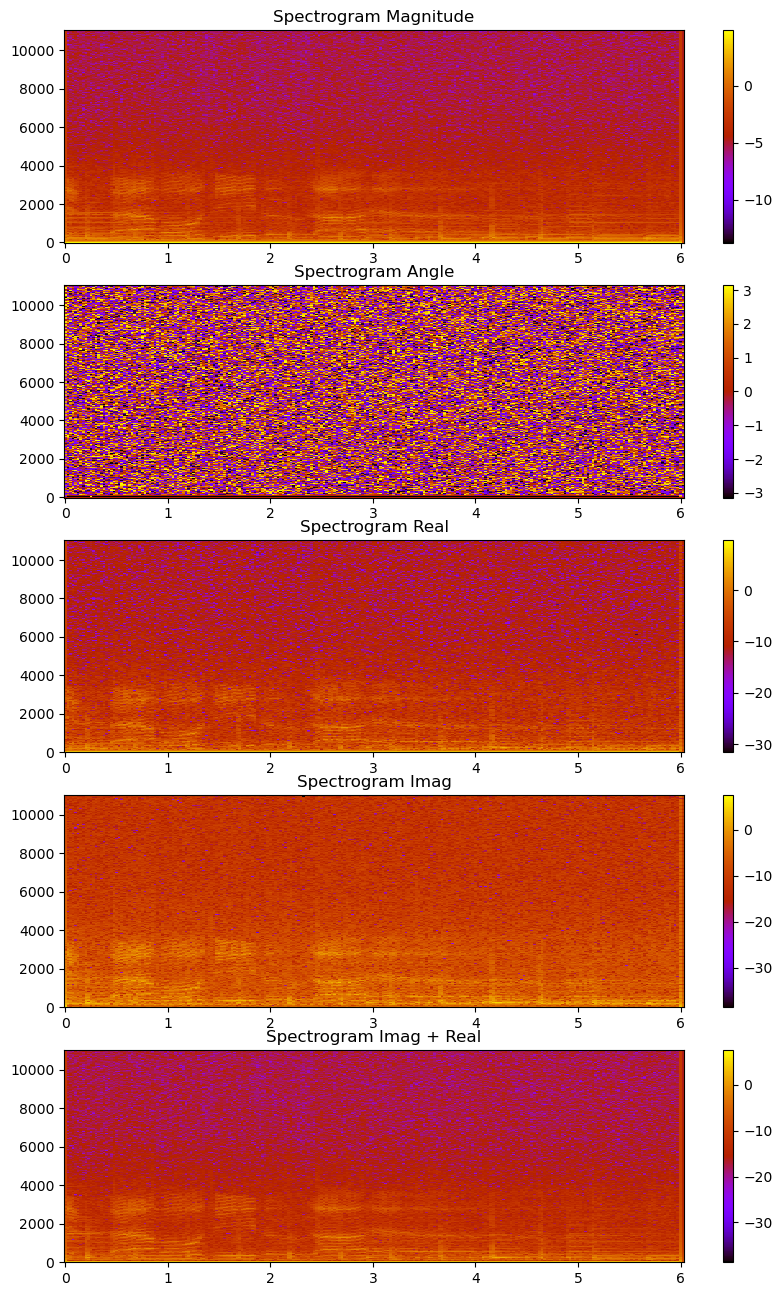

In [8]:
train_dataset.spectrograms(7)

In [9]:
# Create PyTorch Datasets and DataLoaders for training and testing
# Define the root directory where data is stored
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

print('Data loaders created successfully.')

Data loaders created successfully.


In [10]:
# Define the model
class MusicNet(nn.Module):
    def __init__(self):
        super(MusicNet, self).__init__()

        self.cLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, stride=1, padding='same', groups=4),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.cLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.cLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.cLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same'),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fLayer = nn.Sequential(
            nn.Linear(in_features=512*34*15, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x, return_features=False):
        x = self.cLayer1(x)
        x = self.cLayer2(x)
        x = self.cLayer3(x)
        x = self.cLayer4(x)
        
        x = x.view(x.shape[0], 512*34*15)       # Flatten before passing to fully connected layers

        if not return_features:
            x = self.fLayer(x)
             
        return x

# Instantiate the model
model = MusicNet().to(device)

# Print the model architecture
print(model)

MusicNet(
  (cLayer1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=4)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # includes softmax function
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print('Model, loss function, and optimizer are set up.')

Model, loss function, and optimizer are set up.


In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [13]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=5, patience=5):
    time_start = time()
    early_stopping = EarlyStopping(patience=patience)
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() 

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        val_loss /= len(test_loader)
        avg_loss = total_loss / len(train_loader)
        
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_loss:.4f}', Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break


    time_stop = time()
    time_elapsed = time_stop - time_start
    print(f'elapsed time {round(time_elapsed,1)} sec.')

train_model(model, train_loader, criterion, optimizer, epochs=100, patience=2)

Epoch [1/100], Training Loss: 2.0772', Validation Loss: 2.0401, Validation Accuracy: 26.42%
Epoch [2/100], Training Loss: 1.6815', Validation Loss: 1.6933, Validation Accuracy: 37.24%
Epoch [3/100], Training Loss: 1.2812', Validation Loss: 1.3170, Validation Accuracy: 52.55%
Epoch [4/100], Training Loss: 0.9822', Validation Loss: 1.3056, Validation Accuracy: 56.89%
Epoch [5/100], Training Loss: 0.7971', Validation Loss: 1.4289, Validation Accuracy: 59.61%
Epoch [6/100], Training Loss: 0.6356', Validation Loss: 1.3543, Validation Accuracy: 59.23%
Early stopping triggered
elapsed time 26936.2 sec.


In [14]:
model_path = "MusicGenreClassifier.pth"
torch.save(model.state_dict(), model_path)

In [15]:
# Testing loop
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the test dataset: {accuracy:.2f}%')

test_model(model, test_loader)

Test Accuracy of the model on the test dataset: 59.23%


In [16]:
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing
1/0

ZeroDivisionError: division by zero